In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Multiply, Permute, Flatten, RepeatVector, Softmax
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler

In [2]:
import data as data_file

X_train, X_test, y_train, y_test, scaler, data = data_file.main()

print("Train size:", X_train.shape, "Test size:", X_test.shape, "Data size:", data.shape)

[*********************100%***********************]  1 of 1 completed


Columns in the data: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Columns in the data: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
           Adj Close          Close           High            Low  \
count   75006.000000   75006.000000   75006.000000   75006.000000   
mean    86983.384923   86983.384923   86983.385527   86983.384923   
std     12065.775859   12065.775859   12065.776322   12065.775859   
min     65198.042969   65198.042969   65198.042969   65198.042969   
25%     72531.691406   72531.691406   72531.691406   72531.691406   
50%     96477.439955   96477.439955   96477.441262   96477.439955   
75%     96477.439955   96477.439955   96477.441262   96477.439955   
max    101899.515625  101899.515625  101899.515625  101899.515625   

                Open        Volume  
count   75006.000000  7.500600e+04  
mean    86983.385527  1.912998e+07  
std     12065.776322  1.079056e+08  
min     65198.042969  0.000000

In [3]:
def attention_block(inputs):
    attention = Dense(1, activation='tanh')(inputs)  # Học trọng số
    attention = Flatten()(attention)  # Đưa về dạng 1D
    attention = Softmax()(attention)  # Softmax layer
    attention = RepeatVector(K.int_shape(inputs)[2])(attention)  # Lặp lại trọng số theo chiều features
    attention = Permute([2, 1])(attention)  # Hoán vị để phù hợp với inputs
    weighted_inputs = Multiply()([inputs, attention])  # Nhân trọng số với inputs
    return weighted_inputs

# Xây dựng mô hình với Attention
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM Layer 1
lstm_out_1 = LSTM(128, activation='relu', return_sequences=True)(inputs)
lstm_out_1 = Dropout(0.1)(lstm_out_1)

# Attention Layer
attention_out = attention_block(lstm_out_1)

# LSTM Layer 2
lstm_out_2 = LSTM(64, activation='relu', return_sequences=False)(attention_out)
lstm_out_2 = Dropout(0.1)(lstm_out_2)

# Output Layer
output = Dense(1)(lstm_out_2)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

print(model.summary())

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100, 128)  │     69,120 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100, 128)  │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 1)    │        129 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 100)       │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 128, 100)  │          0 │ softmax[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 100, 128)  │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 100, 128)  │          0 │ dropout[0][0],    │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     49,408 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 118,722 (463.76 KB)

 Trainable params: 118,722 (463.76 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 133s 88ms/step - loss: 917.5999 - mae: 917.5999 - val_loss: 0.2649 - val_mae: 0.2649
Epoch 2/50
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 120s 80ms/step - loss: 0.5577 - mae: 0.5577 - val_loss: 0.1029 - val_mae: 0.1029
Epoch 3/50
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 118s 78ms/step - loss: 0.1072 - mae: 0.1072 - val_loss: 0.0917 - val_mae: 0.0917
Epoch 4/50
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 127s 84ms/step - loss: 0.1009 - mae: 0.1009 - val_loss: 0.0855 - val_mae: 0.0855
Epoch 5/50
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 132s 88ms/step - loss: 0.0979 - mae: 0.0979 - val_loss: 0.0862 - val_mae: 0.0862
Epoch 6/50
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 134s 89ms/step - loss: 0.0972 - mae: 0.0972 - val_loss: 0.0871 - val_mae: 0.0871
Epoch 7/50
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 137s 91ms/step - loss: 1377456896.0000 - mae: 1377456896.0000 - val_loss: 0.2587 - val_mae: 0.2587
Epoch 8/50
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 142s 95ms/step - loss: 0.2494 - mae: 0.2494 - val_loss: 0.1570 - val_m

In [4]:
y_pred = model.predict(X_test)

print("Shape of predictions:", y_pred.shape)

469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step
Shape of predictions: (14982, 1)


In [5]:
# Chuyển đổi giá trị dự đoán và thực tế về thang đo gốc
y_pred_original = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], data.shape[1] - 1))), axis=1))[:, 0]
y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1))), axis=1))[:, 0]

In [6]:
mse_original = mean_squared_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mse_original)
mae_original = mean_absolute_error(y_test_original, y_pred_original)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE Original: {mse_original}")
print(f"RMSE Original: {rmse_original}")
print(f"MAE Original: {mae_original}")

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

MSE Original: 51588398.54030566
RMSE Original: 7182.506424661635
MAE Original: 3122.3120769741563
MSE: 0.03829879101279714
RMSE: 0.19570076906542072
MAE: 0.08507320962889073


          Thời gian  Dự đoán (Predicted)  Giá trị thật (Actual)  Sai số (Error)
2024-12-06 00:10:00         70802.607483           68963.703125     1838.904358
2024-12-06 00:11:00         70824.459202           96477.439955    25652.980753
2024-12-06 00:12:00         70891.070959           69506.289062     1384.781897
2024-12-06 00:13:00         71010.499606           68960.210938     2050.288668
2024-12-06 00:14:00         71160.729354           96477.439955    25316.710601
2024-12-06 00:15:00         71344.328420           96477.439955    25133.111535
2024-12-06 00:16:00         71568.957704           96477.439955    24908.482251
2024-12-06 00:17:00         71820.594829           68529.968750     3290.626079
2024-12-06 00:18:00         72093.121139           96477.439955    24384.318816
2024-12-06 00:19:00         72366.979684           96477.439955    24110.460272


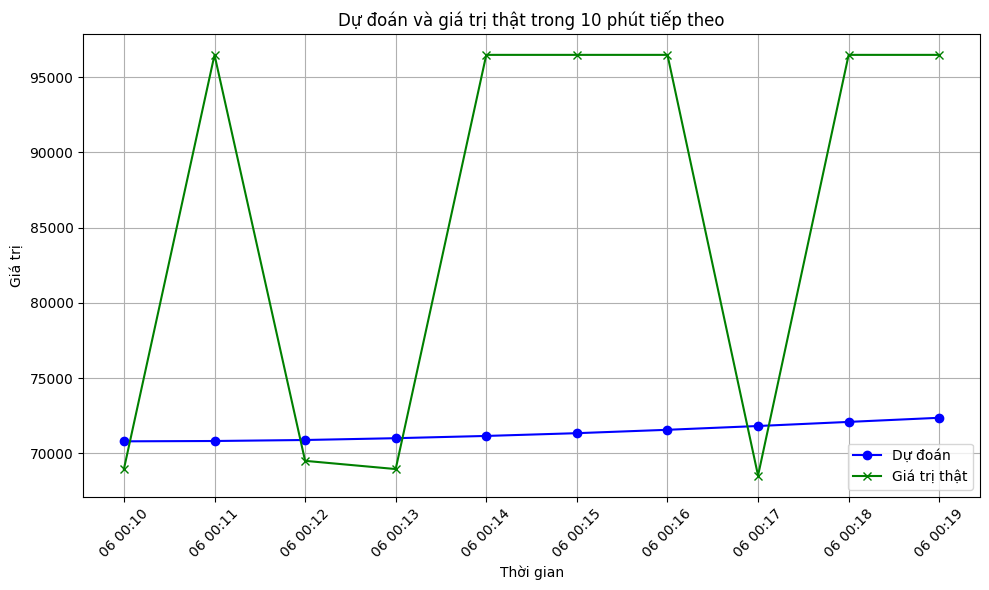

In [7]:
# Giả sử time_index_test chứa thời gian của X_test
time_index_test = pd.date_range(start="2024-12-06", periods=len(X_test), freq="T")

# Hàm nhận vào ngày giờ và lấy record tương ứng trong X_test
def get_test_record_by_datetime(input_datetime):
    # Tính sự khác biệt giữa các thời điểm trong time_index_test và input_datetime
    time_diff = (time_index_test - input_datetime).total_seconds()  # Chuyển sự khác biệt thành giây
    
    # Tìm chỉ số của thời gian gần nhất
    closest_time_index = np.argmin(np.abs(time_diff))  # Tìm chỉ số có sự khác biệt nhỏ nhất
    return closest_time_index

# Bước 1: Nhập vào thời gian muốn kiểm tra
input_datetime = pd.Timestamp('2024-12-06 00:10')  # Ví dụ thời gian

# Lấy index tương ứng với thời gian nhập vào
index_for_input = get_test_record_by_datetime(input_datetime)

# Lấy X_current tương ứng với chỉ số này
X_current = X_test[index_for_input]

# Khởi tạo danh sách kết quả
future_predictions = []
actual_values = []  # Danh sách để lưu các giá trị thực tế
errors = []

# Dự đoán liên tục trong 10 phút
for i in range(10):
    # Dự đoán giá trị tiếp theo
    next_pred = model.predict(X_current.reshape(1, X_current.shape[0], X_current.shape[1]), verbose=0)[0, 0]  # Dự đoán với mẫu X_current

    # Lấy giá trị thực tế từ y_test
    actual_value = y_test[index_for_input + i]

    # Tính sai số tuyệt đối giữa dự đoán và giá trị thực tế
    error = np.abs(next_pred - actual_value)

    # Thêm giá trị dự đoán, giá trị thực tế và sai số vào danh sách
    future_predictions.append(next_pred)
    actual_values.append(actual_value)
    errors.append(error)

    # Cập nhật đầu vào cho lần dự đoán tiếp theo
    X_current = np.roll(X_current, -1, axis=0)  # Lăn dữ liệu về bên trái (giữ lại 99 bước trước đó)
    X_current[-1] = np.array([next_pred] * X_current.shape[1])  # Thay thế giá trị cuối cùng bằng dự đoán mới

# Chuyển đổi giá trị thật (Actual) về thang đo gốc
actual_values_array = np.array(actual_values).reshape(-1, 1)
actual_values_extended = np.zeros((len(actual_values), X_train.shape[2]))
actual_values_extended[:, 0] = actual_values_array[:, 0]

actual_values_original = scaler.inverse_transform(actual_values_extended)[:, 0]

# Chuyển đổi giá trị dự đoán (Predicted) về thang đo gốc
future_predictions_array = np.array(future_predictions).reshape(-1, 1)
future_predictions_extended = np.zeros((len(future_predictions), X_train.shape[2]))
future_predictions_extended[:, 0] = future_predictions_array[:, 0]

future_predictions_original = scaler.inverse_transform(future_predictions_extended)[:, 0]

# Chuyển đổi sai số (Error) về thang đo gốc
errors_original = np.abs(actual_values_original - future_predictions_original)

# Tạo DataFrame để hiển thị các giá trị dự đoán, giá trị thực tế và sai số
future_df = pd.DataFrame({
    "Thời gian": time_index_test[index_for_input:index_for_input+10],
    "Dự đoán (Predicted)": future_predictions_original,
    "Giá trị thật (Actual)": actual_values_original,
    "Sai số (Error)": errors_original
})

# Hiển thị kết quả dự đoán, giá trị thật và sai số
print(future_df.to_string(index=False))

# Vẽ biểu đồ kết quả
plt.figure(figsize=(10, 6))
plt.plot(future_df["Thời gian"], future_df["Dự đoán (Predicted)"], marker='o', label="Dự đoán", color='b')
plt.plot(future_df["Thời gian"], future_df["Giá trị thật (Actual)"], marker='x', label="Giá trị thật", color='g')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.title('Dự đoán và giá trị thật trong 10 phút tiếp theo')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
